In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, QED, GraphDescriptors
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler


In [2]:
def smiles_to_ecfp4_safe(smiles, n_bits=1024):
    """ECFP4 generation with error handling"""
    try:
        # Check if SMILES is valid string
        if not isinstance(smiles, str) or pd.isna(smiles) or len(smiles.strip()) == 0:
            return None
            
        mol = Chem.MolFromSmiles(smiles.strip())
        if mol is None:
            return None
            
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
        return fp.ToBitString()  # Convert to bit string for CSV storage
        
    except Exception as e:
        print(f"ECFP4 error for '{smiles}': {str(e)}")
        return None

def get_molecular_descriptors_safe(smiles):
    """Molecular descriptor calculation with error handling"""
    try:
        # Check if SMILES is valid string
        if not isinstance(smiles, str) or pd.isna(smiles) or len(smiles.strip()) == 0:
            return None
            
        mol = Chem.MolFromSmiles(smiles.strip())
        if mol is None:
            return None
            
        return {
            'MolWt': Descriptors.MolWt(mol),
            'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
            'NumRotatableBonds': rdMolDescriptors.CalcNumRotatableBonds(mol),
            'TPSA': Descriptors.TPSA(mol),
            'LabuteASA': rdMolDescriptors.CalcLabuteASA(mol),
            'MolLogP': rdMolDescriptors.CalcCrippenDescriptors(mol)[0],
            'MolMR': rdMolDescriptors.CalcCrippenDescriptors(mol)[1],
            'FractionCSP3': rdMolDescriptors.CalcFractionCSP3(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'RingCount': Descriptors.RingCount(mol),
            'QED': QED.qed(mol),
            'BalabanJ': GraphDescriptors.BalabanJ(mol),
            'BertzCT': GraphDescriptors.BertzCT(mol),
            'Ipc': GraphDescriptors.Ipc(mol),
            'FormalCharge': Chem.GetFormalCharge(mol),
            'RadicalElectrons': Descriptors.NumRadicalElectrons(mol)
        }
        
    except Exception as e:
        print(f"Descriptor error for '{smiles}': {str(e)}")
        return None

def process_dataset_safe(df):
    """Process entire dataset with comprehensive error handling"""
    print(f"Processing {len(df)} compounds...")
    
    # Clean SMILES column
    df['SMILES'] = df['SMILES'].astype(str)
    df = df[~df['SMILES'].isin(['nan', 'NaN', '', 'None'])]
    
    valid_data = []
    invalid_count = 0
    
    for idx, row in df.iterrows():
        # Process descriptors
        descriptors = get_molecular_descriptors_safe(row['SMILES'])
        
        # Process ECFP4
        ecfp4 = smiles_to_ecfp4_safe(row['SMILES'])
        
        if descriptors is not None and ecfp4 is not None:
            # Combine all data
            combined_data = {
                'SMILES': row['SMILES'],
                'ECFP4': ecfp4,
                'I' : row['I'],
                'II': row['II'],
                'III':row['III'],
                'IV': row['IV']
            }
            combined_data.update(descriptors)
            valid_data.append(combined_data)
        else:
            invalid_count += 1
            print(f"Skipped compound {row['Compound ID']} due to processing errors")
    
    print(f"Successfully processed: {len(valid_data)}/{len(df)} compounds")
    print(f"Failed processing: {invalid_count} compounds")
    
    return pd.DataFrame(valid_data)

In [7]:
df = pd.read_csv('BCS_drugs.csv')  
processed_df = process_dataset_safe(df)
processed_df.head()

Processing 393 compounds...


[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerator
[12:00:15] DEPRECATION WARNING: please use MorganGenerat

Successfully processed: 386/386 compounds
Failed processing: 0 compounds


[12:00:19] DEPRECATION WARNING: please use MorganGenerator
[12:00:19] DEPRECATION WARNING: please use MorganGenerator
[12:00:19] DEPRECATION WARNING: please use MorganGenerator


,SMILES,ECFP4,I,II,III,IV,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,...,FractionCSP3,NumHDonors,NumHAcceptors,RingCount,QED,BalabanJ,BertzCT,Ipc,FormalCharge,RadicalElectrons
0,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)[C@@H]4C[C@@H](C...,0000000011000000000000100000000000000000000000...,0,0,1,0,286.339,21,4,101.88,...,0.500000,3,7,4,0.727230,1.733957,704.797299,1.282894e+05,0,0
1,CC(=O)O[C@H]1CC[C@@]2([C@H]3CC[C@]4([C@H]([C@@...,0000000100010000100100000000000001001000000000...,0,0,0,1,391.555,29,2,39.19,...,0.615385,0,3,5,0.460458,1.408937,871.954338,5.686486e+06,0,0
2,CCCS(=O)(=O)N[C@H]1C[C@H](C1)N(C)C1=C2C=CNC2=N...,0010000000000000000000000000000001000000000000...,0,1,0,0,323.422,22,6,90.98,...,0.571429,2,5,3,0.834810,1.643007,751.433899,9.632255e+04,0,0
3,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl,0000000000000001000000000000000000000000000000...,0,1,0,0,354.189,23,6,75.63,...,0.125000,2,4,2,0.769662,2.175371,713.520217,1.250883e+05,0,0
4,CC(=O)NC1=CC=C(C=C1)O,0000000000000000000000000000000001000000000000...,0,0,1,0,151.165,11,1,49.33,...,0.125000,2,2,1,0.595026,2.736298,253.299498,2.855107e+02,0,0


In [9]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SMILES             386 non-null    object 
 1   ECFP4              386 non-null    object 
 2   I                  386 non-null    int64  
 3   II                 386 non-null    int64  
 4   III                386 non-null    int64  
 5   IV                 386 non-null    int64  
 6   MolWt              386 non-null    float64
 7   HeavyAtomCount     386 non-null    int64  
 8   NumRotatableBonds  386 non-null    int64  
 9   TPSA               386 non-null    float64
 10  LabuteASA          386 non-null    float64
 11  MolLogP            386 non-null    float64
 12  MolMR              386 non-null    float64
 13  FractionCSP3       386 non-null    float64
 14  NumHDonors         386 non-null    int64  
 15  NumHAcceptors      386 non-null    int64  
 16  RingCount          386 non

In [66]:
def bitstring_to_array(bitstr):
    return np.array([int(c) for c in bitstr], dtype=np.int8)

ecfp_matrix = np.vstack(processed_df['ECFP4'].apply(bitstring_to_array))
ecfp_df = pd.DataFrame(ecfp_matrix, columns=[f'ECFP4_{i}' for i in range(1024)])

X_descriptors = processed_df.drop(['I','II','III','IV', 'ECFP4','SMILES'], axis=1)

continuous_features = [
    'MolWt', 'LabuteASA', 'MolLogP', 'MolMR',
    'FractionCSP3', 'BalabanJ', 'BertzCT', 'Ipc'
]

count_features = [
    'HeavyAtomCount', 'NumRotatableBonds',
    'NumHAcceptors', 'NumHDonors', 'RingCount',
    'FormalCharge', 'RadicalElectrons'
]

preprocessor = ColumnTransformer([
    ('robust', RobustScaler(quantile_range=(25, 75)), continuous_features),
    ('minmax', MinMaxScaler(feature_range=(-1, 1)), ['QED']),
    ('count', 'passthrough', count_features)
], remainder='drop')

In [68]:
X_processed = preprocessor.fit_transform(X_descriptors)
processed_columns = continuous_features + ['QED'] + count_features

#Combine with ECFP4 features
X_final = np.hstack([X_processed, ecfp_matrix])
all_columns = processed_columns + ecfp_df.columns.tolist()

In [23]:
import joblib

In [15]:
import joblib

model_lgbm = joblib.load('lgbm_model.pkl')

all_columns = joblib.load('lgbm_feature_names.pkl')
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

In [17]:
processed_df['logS'] = model_lgbm.predict(X_final)

In [19]:
processed_df.head()

,SMILES,ECFP4,I,II,III,IV,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,...,NumHDonors,NumHAcceptors,RingCount,QED,BalabanJ,BertzCT,Ipc,FormalCharge,RadicalElectrons,logS
0,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)[C@@H]4C[C@@H](C...,0000000011000000000000100000000000000000000000...,0,0,1,0,286.339,21,4,101.88,...,3,7,4,0.727230,1.733957,704.797299,1.282894e+05,0,0,-1.406260
1,CC(=O)O[C@H]1CC[C@@]2([C@H]3CC[C@]4([C@H]([C@@...,0000000100010000100100000000000001001000000000...,0,0,0,1,391.555,29,2,39.19,...,0,3,5,0.460458,1.408937,871.954338,5.686486e+06,0,0,-5.782504
2,CCCS(=O)(=O)N[C@H]1C[C@H](C1)N(C)C1=C2C=CNC2=N...,0010000000000000000000000000000001000000000000...,0,1,0,0,323.422,22,6,90.98,...,2,5,3,0.834810,1.643007,751.433899,9.632255e+04,0,0,-1.911652
3,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl,0000000000000001000000000000000000000000000000...,0,1,0,0,354.189,23,6,75.63,...,2,4,2,0.769662,2.175371,713.520217,1.250883e+05,0,0,-3.231948
4,CC(=O)NC1=CC=C(C=C1)O,0000000000000000000000000000000001000000000000...,0,0,1,0,151.165,11,1,49.33,...,2,2,1,0.595026,2.736298,253.299498,2.855107e+02,0,0,-0.060698


In [31]:
processed_df['MolLogP'].head()

0    1.0923
1    5.9694
2    1.2545
3    3.9073
4    1.3506
Name: MolLogP, dtype: float64

In [33]:
processed_df.to_csv('BCS_drugs_l.csv', index=False)
print(f"Final dataset shape: {processed_df.shape}")

Final dataset shape: (386, 24)


In [21]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SMILES             386 non-null    object 
 1   ECFP4              386 non-null    object 
 2   I                  386 non-null    int64  
 3   II                 386 non-null    int64  
 4   III                386 non-null    int64  
 5   IV                 386 non-null    int64  
 6   MolWt              386 non-null    float64
 7   HeavyAtomCount     386 non-null    int64  
 8   NumRotatableBonds  386 non-null    int64  
 9   TPSA               386 non-null    float64
 10  LabuteASA          386 non-null    float64
 11  MolLogP            386 non-null    float64
 12  MolMR              386 non-null    float64
 13  FractionCSP3       386 non-null    float64
 14  NumHDonors         386 non-null    int64  
 15  NumHAcceptors      386 non-null    int64  
 16  RingCount          386 non

In [39]:
processed_df.head(10)

,SMILES,ECFP4,I,II,III,IV,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,...,NumHDonors,NumHAcceptors,RingCount,QED,BalabanJ,BertzCT,Ipc,FormalCharge,RadicalElectrons,logS
0,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)[C@@H]4C[C@@H](C...,0000000011000000000000100000000000000000000000...,0,0,1,0,286.339,21,4,101.88,...,3,7,4,0.727230,1.733957,704.797299,1.282894e+05,0,0,-1.406260
1,CC(=O)O[C@H]1CC[C@@]2([C@H]3CC[C@]4([C@H]([C@@...,0000000100010000100100000000000001001000000000...,0,0,0,1,391.555,29,2,39.19,...,0,3,5,0.460458,1.408937,871.954338,5.686486e+06,0,0,-5.782504
2,CCCS(=O)(=O)N[C@H]1C[C@H](C1)N(C)C1=C2C=CNC2=N...,0010000000000000000000000000000001000000000000...,0,1,0,0,323.422,22,6,90.98,...,2,5,3,0.834810,1.643007,751.433899,9.632255e+04,0,0,-1.911652
3,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl,0000000000000001000000000000000000000000000000...,0,1,0,0,354.189,23,6,75.63,...,2,4,2,0.769662,2.175371,713.520217,1.250883e+05,0,0,-3.231948
4,CC(=O)NC1=CC=C(C=C1)O,0000000000000000000000000000000001000000000000...,0,0,1,0,151.165,11,1,49.33,...,2,2,1,0.595026,2.736298,253.299498,2.855107e+02,0,0,-0.060698
5,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,0000000000000000000000000000000011000000000000...,0,0,0,1,222.251,13,2,115.04,...,2,6,1,0.631859,2.938691,422.352468,6.821273e+02,0,0,-0.196613
6,CC(=O)OC1=CC=CC=C1C(=O)O,0000000000010000000000010000000001000000000000...,1,0,0,0,180.159,13,2,63.60,...,1,3,1,0.550122,3.043527,343.222868,7.296808e+02,0,0,-0.060437
7,C1=NC2=C(N1COCCO)N=C(NC2=O)N,0000000000000100000000000000000000000000000001...,0,0,1,0,225.208,16,4,119.05,...,3,7,2,0.554386,2.360788,546.087625,5.884228e+03,0,0,-1.340973
8,CN(C)C/C=C/C(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=C...,0000000000000000000000000010000101100000000000...,1,0,1,0,485.947,34,8,88.61,...,2,7,4,0.457293,1.680261,1214.677845,5.286796e+07,0,0,-3.766254
9,CCCSC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,0000000000000100100000000000000001000000000000...,0,1,0,1,265.338,18,4,67.01,...,2,4,2,0.832712,2.193990,553.246141,1.666472e+04,0,0,-2.898554


In [5]:
processed_df = pd.read_csv('BCS_drugs_l.csv')

In [7]:
processed_df.head()

,SMILES,ECFP4,I,II,III,IV,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,...,NumHDonors,NumHAcceptors,RingCount,QED,BalabanJ,BertzCT,Ipc,FormalCharge,RadicalElectrons,logS
0,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)[C@@H]4C[C@@H](C...,0000000011000000000000100000000000000000000000...,0,0,1,0,286.339,21,4,101.88,...,3,7,4,0.727230,1.733957,704.797299,1.282894e+05,0,0,-1.406260
1,CC(=O)O[C@H]1CC[C@@]2([C@H]3CC[C@]4([C@H]([C@@...,0000000100010000100100000000000001001000000000...,0,0,0,1,391.555,29,2,39.19,...,0,3,5,0.460458,1.408937,871.954338,5.686486e+06,0,0,-5.782504
2,CCCS(=O)(=O)N[C@H]1C[C@H](C1)N(C)C1=C2C=CNC2=N...,0010000000000000000000000000000001000000000000...,0,1,0,0,323.422,22,6,90.98,...,2,5,3,0.834810,1.643007,751.433899,9.632255e+04,0,0,-1.911652
3,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl,0000000000000001000000000000000000000000000000...,0,1,0,0,354.189,23,6,75.63,...,2,4,2,0.769662,2.175371,713.520217,1.250883e+05,0,0,-3.231948
4,CC(=O)NC1=CC=C(C=C1)O,0000000000000000000000000000000001000000000000...,0,0,1,0,151.165,11,1,49.33,...,2,2,1,0.595026,2.736298,253.299498,2.855107e+02,0,0,-0.060698


## Random Forest

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = processed_df[['logS','MolLogP']]

Y = processed_df[['I', 'II', 'III', 'IV']]

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Multi-output model
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

In [11]:
# Predict on test set
Y_pred = clf.predict(X_test)

In [13]:
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
print(classification_report(Y_test, Y_pred, target_names=['I','II','III','IV']))
print('Hamming Loss:', hamming_loss(Y_test, Y_pred))
print('Jaccard Score:', jaccard_score(Y_test, Y_pred, average='samples'))


              precision    recall  f1-score   support

           I       0.29      0.29      0.29        21
          II       0.63      0.61      0.62        28
         III       0.44      0.28      0.34        25
          IV       0.17      0.07      0.10        15

   micro avg       0.44      0.35      0.39        89
   macro avg       0.38      0.31      0.34        89
weighted avg       0.42      0.35      0.37        89
 samples avg       0.37      0.35      0.35        89

Hamming Loss: 0.3108974358974359
Jaccard Score: 0.32051282051282054


C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


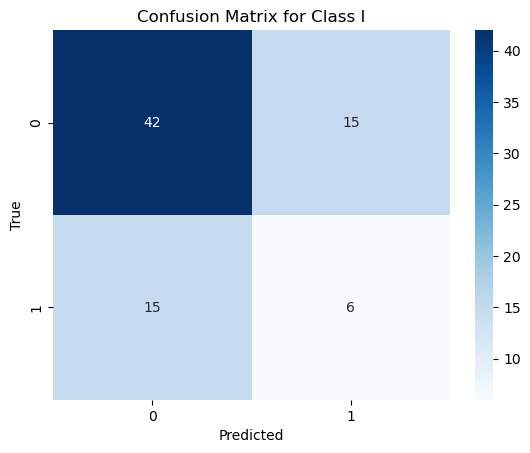

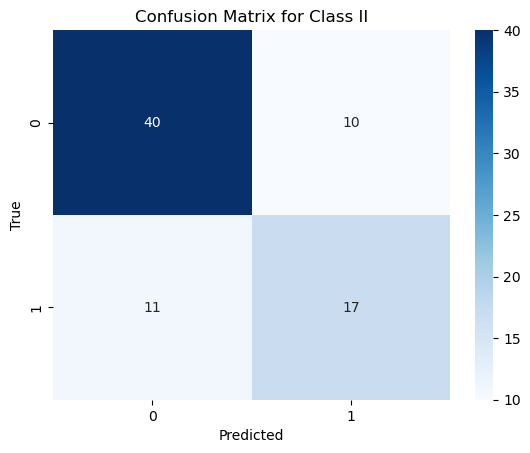

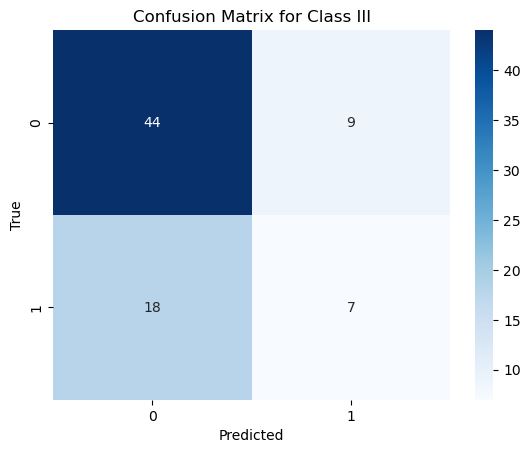

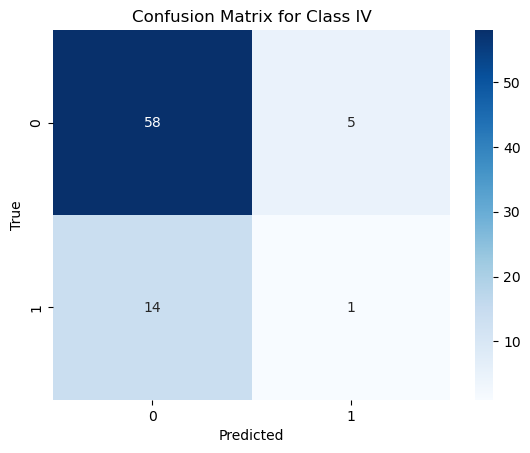

In [15]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Y_test and Y_pred each have shape (n_samples, 4)
# and columns are in order: ['I', 'II', 'III', 'IV']
cm = multilabel_confusion_matrix(Y_test, Y_pred)

labels = ['I', 'II', 'III', 'IV']
for i, label in enumerate(labels):
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for Class {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [17]:
importances = clf.feature_importances_
print(f"logS importance: {importances[0]:.3f}, logP importance: {importances[1]:.3f}")


logS importance: 0.497, logP importance: 0.503


In [19]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

overall_acc = accuracy_score(Y_test, Y_pred)

# Macro & weighted precision/recall/F1
macro_prec  = precision_score(Y_test, Y_pred, average='macro', zero_division=0)
macro_rec   = recall_score(Y_test, Y_pred, average='macro', zero_division=0)
macro_f1    = f1_score(Y_test, Y_pred, average='macro', zero_division=0)

weighted_prec  = precision_score(Y_test, Y_pred, average='weighted', zero_division=0)
weighted_rec   = recall_score(Y_test, Y_pred, average='weighted', zero_division=0)
weighted_f1    = f1_score(Y_test, Y_pred, average='weighted', zero_division=0)

print("=== Overall Performance ===")
print(f"Overall Accuracy: {overall_acc:.3f}")
print(f"Macro Precision: {macro_prec:.3f}")
print(f"Macro Recall:    {macro_rec:.3f}")
print(f"Macro F1:        {macro_f1:.3f}")
print(f"Weighted Precision: {weighted_prec:.3f}")
print(f"Weighted Recall:    {weighted_rec:.3f}")
print(f"Weighted F1:        {weighted_f1:.3f}")

# ---- Per-class metrics ----
print("\n=== Per-class metrics ===")
for i, label in enumerate(labels):
    tn, fp, fn, tp = cm[i].ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0
    print(f"Class {label}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")


=== Overall Performance ===
Overall Accuracy: 0.244
Macro Precision: 0.380
Macro Recall:    0.310
Macro F1:        0.335
Weighted Precision: 0.416
Weighted Recall:    0.348
Weighted F1:        0.374

=== Per-class metrics ===
Class I: Acc=0.615, Prec=0.286, Rec=0.286, F1=0.286
Class II: Acc=0.731, Prec=0.630, Rec=0.607, F1=0.618
Class III: Acc=0.654, Prec=0.438, Rec=0.280, F1=0.341
Class IV: Acc=0.756, Prec=0.167, Rec=0.067, F1=0.095


In [43]:
import joblib

# Save the trained classifier
joblib.dump(clf, "random_forest_classifier.pkl")

# Save the feature names (for consistency during inference)
joblib.dump(X.columns.tolist(), "rf_feature_names.pkl")

print("✅ Random Forest Classifier saved as random_forest_classifier.pkl")


✅ Random Forest Classifier saved as random_forest_classifier.pkl


## With other parameters

In [21]:
X = processed_df.drop(['SMILES','ECFP4','I', 'II', 'III', 'IV', 'BalabanJ', 'BertzCT', 'Ipc'],axis=1)

Y = processed_df[['I', 'II', 'III', 'IV']]

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Multi-output model
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

In [25]:
# Predict on test set
Y_pred = clf.predict(X_test)

In [27]:
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
print(classification_report(Y_test, Y_pred, target_names=['I','II','III','IV']))
print('Hamming Loss:', hamming_loss(Y_test, Y_pred))
print('Jaccard Score:', jaccard_score(Y_test, Y_pred, average='samples'))


              precision    recall  f1-score   support

           I       0.40      0.29      0.33        21
          II       0.59      0.57      0.58        28
         III       0.64      0.28      0.39        25
          IV       1.00      0.13      0.24        15

   micro avg       0.56      0.35      0.43        89
   macro avg       0.66      0.32      0.38        89
weighted avg       0.63      0.35      0.41        89
 samples avg       0.39      0.36      0.37        89

Hamming Loss: 0.26282051282051283
Jaccard Score: 0.3525641025641026


C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


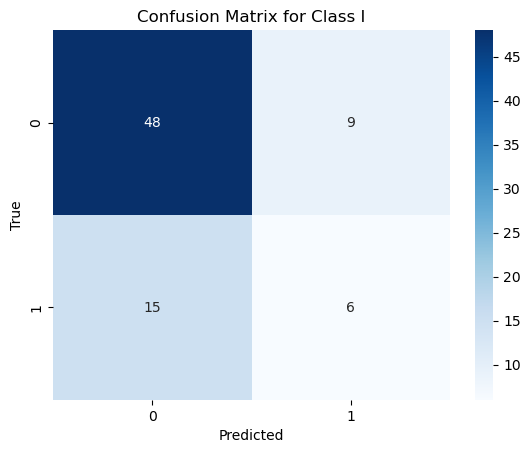

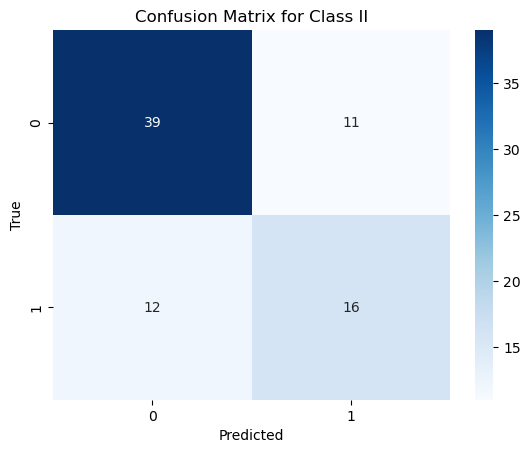

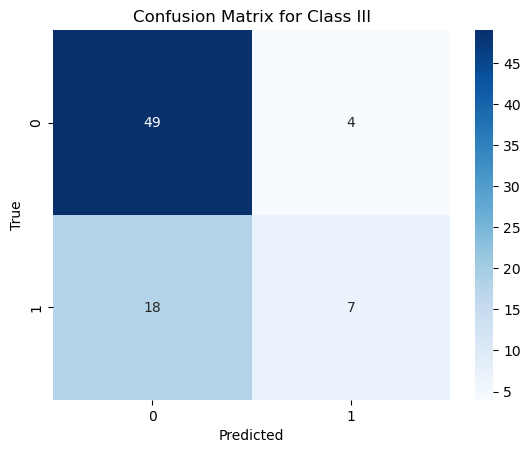

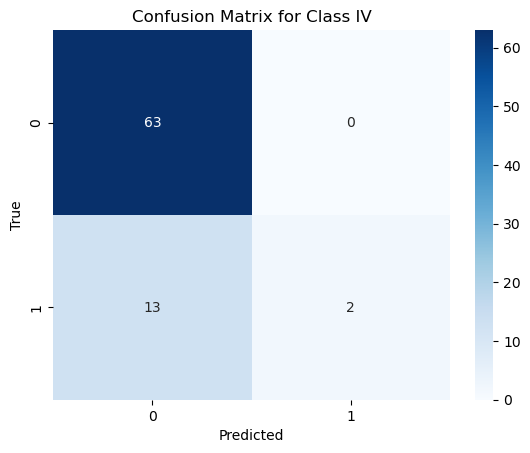

In [29]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Y_test and Y_pred each have shape (n_samples, 4)
# and columns are in order: ['I', 'II', 'III', 'IV']
cm = multilabel_confusion_matrix(Y_test, Y_pred)

labels = ['I', 'II', 'III', 'IV']
for i, label in enumerate(labels):
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for Class {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## SVM

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, hamming_loss, jaccard_score


In [33]:
X = processed_df[['logS', 'MolLogP']]
Y = processed_df[['I', 'II', 'III', 'IV']]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:
# Create One-vs-Rest multi-label classifier with SVM
svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=42))

svm.fit(X_train_scaled, Y_train)
Y_pred = svm.predict(X_test_scaled)


In [39]:
print(classification_report(Y_test, Y_pred, target_names=['I', 'II', 'III', 'IV']))
print('Hamming Loss:', hamming_loss(Y_test, Y_pred))
print('Jaccard Score:', jaccard_score(Y_test, Y_pred, average='samples'))


              precision    recall  f1-score   support

           I       0.31      0.19      0.24        21
          II       0.72      0.75      0.74        28
         III       0.00      0.00      0.00        25
          IV       0.00      0.00      0.00        15

   micro avg       0.58      0.28      0.38        89
   macro avg       0.26      0.24      0.24        89
weighted avg       0.30      0.28      0.29        89
 samples avg       0.32      0.28      0.29        89

Hamming Loss: 0.26282051282051283
Jaccard Score: 0.28205128205128205


C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HariK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


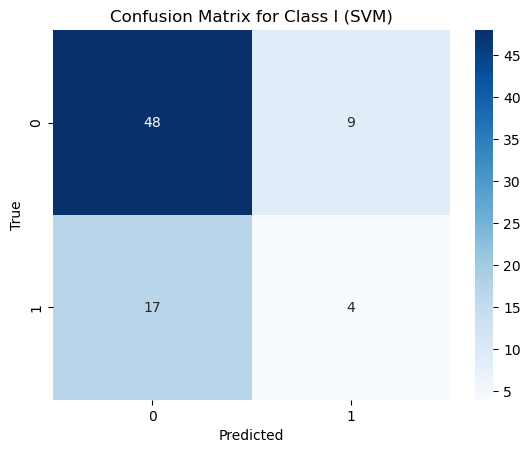

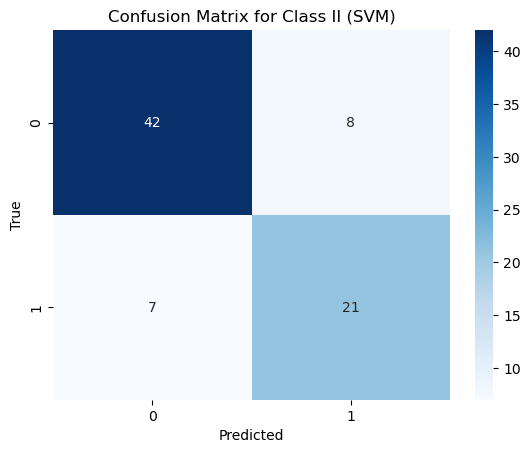

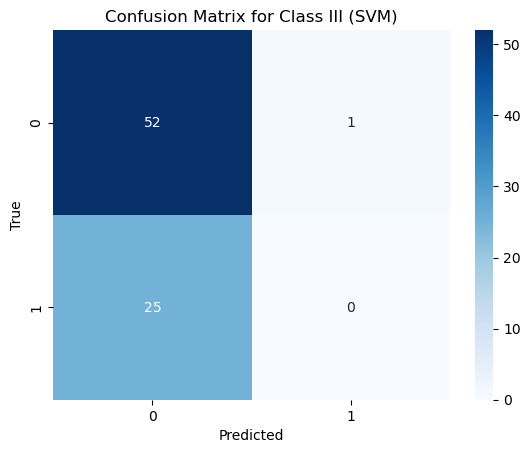

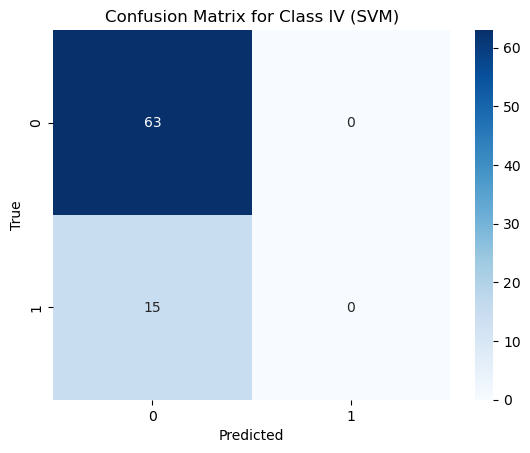

In [41]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Y_test and Y_pred: arrays or DataFrames (n_samples, 4) for classes ['I', 'II', 'III', 'IV']
cm = multilabel_confusion_matrix(Y_test, Y_pred)

labels = ['I', 'II', 'III', 'IV']
for i, label in enumerate(labels):
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for Class {label} (SVM)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## .............................

In [44]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SMILES             386 non-null    object 
 1   ECFP4              386 non-null    object 
 2   I                  386 non-null    int64  
 3   II                 386 non-null    int64  
 4   III                386 non-null    int64  
 5   IV                 386 non-null    int64  
 6   MolWt              386 non-null    float64
 7   HeavyAtomCount     386 non-null    int64  
 8   NumRotatableBonds  386 non-null    int64  
 9   TPSA               386 non-null    float64
 10  LabuteASA          386 non-null    float64
 11  MolLogP            386 non-null    float64
 12  MolMR              386 non-null    float64
 13  FractionCSP3       386 non-null    float64
 14  NumHDonors         386 non-null    int64  
 15  NumHAcceptors      386 non-null    int64  
 16  RingCount          386 non

In [90]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.1/56.8 MB 403.5 kB/s eta 0:02:21
   ---------------------------------------- 0.1/56.8 MB 403.5 kB/s eta 0:02:21
   ---------------------------------------- 0.2/56.8 MB 752.5 kB/s eta 0:01:16
   ---------------------------------------- 0.3/56.8 MB 952.6 kB/s eta 0:01:00
   ------------------------

In [92]:
# PREP: load, impute, scale (same pipeline I used)
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, classification_report

df = pd.read_csv("BCS_drugs_l.csv")  # adjust path
df.replace([np.inf, -np.inf], np.nan, inplace=True)

descriptor_cols = [
 'MolWt','HeavyAtomCount','NumRotatableBonds','TPSA','LabuteASA',
 'MolLogP','MolMR','FractionCSP3','NumHDonors','NumHAcceptors',
 'RingCount','QED','BalabanJ','BertzCT','Ipc','FormalCharge',
 'RadicalElectrons','logS'
]

X = df[descriptor_cols].copy()
Y = df[['I','II','III','IV']].astype(int).values

continuous_features = ['MolWt','LabuteASA','MolLogP','MolMR','FractionCSP3','BalabanJ','BertzCT','Ipc','TPSA','logS']
count_features = ['HeavyAtomCount','NumRotatableBonds','NumHAcceptors','NumHDonors','RingCount','FormalCharge','RadicalElectrons']
qed_feature = ['QED']

continuous_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler(quantile_range=(25,75)))])
count_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median'))])
qed_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler(feature_range=(-1,1)))])

preprocessor = ColumnTransformer([
    ('cont', continuous_pipeline, continuous_features),
    ('qed', qed_pipeline, qed_feature),
    ('count', count_pipeline, count_features)
], remainder='drop')

X_trans = preprocessor.fit_transform(X)
# fix any non-finite values if needed:
X_trans = np.asarray(X_trans, dtype=np.float64)
col_medians = np.nanmedian(np.where(np.isfinite(X_trans), X_trans, np.nan), axis=0)
for j in range(X_trans.shape[1]):
    col = X_trans[:, j]
    bad = ~np.isfinite(col)
    if bad.any(): col[bad] = col_medians[j]
    col[np.abs(col) > 1e6] = np.sign(col[np.abs(col) > 1e6]) * 1e6
    X_trans[:, j] = col

X_train, X_test, y_train, y_test = train_test_split(X_trans, Y, test_size=0.2, random_state=42)

In [94]:
# RandomForest (One-vs-Rest wrapper)
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RF subset_acc:", accuracy_score(y_test, y_pred))
print("RF f1_macro:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=['I','II','III','IV']))

# XGBoost (One-vs-Rest)
xgb = OneVsRestClassifier(XGBClassifier(n_estimators=150, use_label_encoder=False, eval_metric='logloss', n_jobs=1, random_state=42))
xgb.fit(X_train, y_train)
y_pred_x = xgb.predict(X_test)
print("XGB subset_acc:", accuracy_score(y_test, y_pred_x))
print("XGB f1_macro:", f1_score(y_test, y_pred_x, average='macro'))
print(classification_report(y_test, y_pred_x, target_names=['I','II','III','IV']))

RF subset_acc: 0.32051282051282054
RF f1_macro: 0.43058278867102395
              precision    recall  f1-score   support

           I       0.47      0.43      0.45        21
          II       0.73      0.68      0.70        28
         III       0.44      0.16      0.24        25
          IV       1.00      0.20      0.33        15

   micro avg       0.61      0.39      0.48        89
   macro avg       0.66      0.37      0.43        89
weighted avg       0.64      0.39      0.45        89
 samples avg       0.40      0.39      0.39        89

XGB subset_acc: 0.2948717948717949
XGB f1_macro: 0.43234002196266347
              precision    recall  f1-score   support

           I       0.48      0.48      0.48        21
          II       0.56      0.50      0.53        28
         III       0.53      0.36      0.43        25
          IV       0.33      0.27      0.30        15

   micro avg       0.49      0.42      0.45        89
   macro avg       0.47      0.40      0.43     

# Descriptors alone not sufficient for classification
-> class II dominating the model learning

-> XGBoost slightly better accuracy but still not sufficient.

-> Adding ECFP4!!!

In [130]:
# ==========================================================
# 🔹 BCS Classification – Hybrid Model (Descriptors + ECFP4)
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, classification_report

df = processed_df.copy()   # your DataFrame already loaded
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Clip very large magnitude values (some molecular descriptors can blow up)
for col in df.select_dtypes(include=[np.number]).columns:
    # Replace NaN with column median first
    median_val = df[col].median(skipna=True)
    df[col].fillna(median_val, inplace=True)

    # Clip extreme outliers to a safe numeric range (±1e6)
    df[col] = np.clip(df[col], -1e6, 1e6)

# Verify no non-finite or huge values remain
bad_counts = np.isfinite(df.select_dtypes(include=[np.number])).sum().eq(0).sum()
print(f"Data cleaned. Non-finite entries after cleaning: {bad_counts}")
print(df.describe().T[['min', 'max']].head(10))


# descriptor columns
descriptor_cols = [
 'MolWt','HeavyAtomCount','NumRotatableBonds','TPSA','LabuteASA',
 'MolLogP','MolMR','FractionCSP3','NumHDonors','NumHAcceptors',
 'RingCount','QED','BalabanJ','BertzCT','Ipc','FormalCharge',
 'RadicalElectrons','logS'
]

X_desc = df[descriptor_cols].copy()
Y = df[['I','II','III','IV']].astype(int).values


continuous_features = ['MolWt','LabuteASA','MolLogP','MolMR','FractionCSP3','BalabanJ','BertzCT','Ipc','TPSA','logS']
count_features = ['HeavyAtomCount','NumRotatableBonds','NumHAcceptors','NumHDonors','RingCount','FormalCharge','RadicalElectrons']
qed_feature = ['QED']

cont_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler(quantile_range=(25.0,75.0)))])
count_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
qed_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler(feature_range=(-1,1)))])

preprocessor = ColumnTransformer([
    ('cont', cont_pipe, continuous_features),
    ('qed', qed_pipe, qed_feature),
    ('count', count_pipe, count_features)
])

X_desc_scaled = preprocessor.fit_transform(X_desc)


def bitstring_to_array(bitstr):
    """Convert ECFP4 bitstring to binary numpy array."""
    if isinstance(bitstr, str):
        return np.array([int(c) for c in bitstr], dtype=np.int8)
    else:
        return np.zeros(1024, dtype=np.int8)

# Convert column to matrix
print("Converting ECFP4 bitstrings to binary matrix...")
ecfp_matrix = np.vstack(df['ECFP4'].apply(bitstring_to_array).values)
print("ECFP4 shape:", ecfp_matrix.shape)


X_hybrid = np.hstack([X_desc_scaled, ecfp_matrix])
print("Hybrid feature shape:", X_hybrid.shape)

Data cleaned. Non-finite entries after cleaning: 0
                          min          max
I                    0.000000     1.000000
II                   0.000000     1.000000
III                  0.000000     1.000000
IV                   0.000000     1.000000
MolWt              100.086000  4113.641000
HeavyAtomCount       5.000000   291.000000
NumRotatableBonds    0.000000   149.000000
TPSA                 3.240000  1646.180000
LabuteASA           46.628257  1679.728719
MolLogP            -11.627860    11.542500
Converting ECFP4 bitstrings to binary matrix...
ECFP4 shape: (386, 1024)
Hybrid feature shape: (386, 1042)


In [132]:

X_train, X_test, y_train, y_test = train_test_split(X_hybrid, Y, test_size=0.2, random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test, cv_folds=3):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        'subset_acc': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'hamming_loss': hamming_loss(y_test, y_pred),
    }
    # Cross-validation F1
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_macro', n_jobs=-1)
    metrics['cv_f1_mean'] = np.mean(cv_scores)
    metrics['cv_f1_std'] = np.std(cv_scores)
    return metrics, y_pred

# RandomForest (Hybrid)
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
print("\n Training RandomForest (Hybrid)...")
rf_metrics, rf_pred = evaluate_model(rf, X_train, y_train, X_test, y_test)

# XGBoost (Hybrid)
xgb = OneVsRestClassifier(XGBClassifier(
    n_estimators=300, use_label_encoder=False, eval_metric='logloss',
    learning_rate=0.05, max_depth=6, subsample=0.8, n_jobs=-1, random_state=42))
print("\n Training XGBoost (Hybrid)...")
xgb_metrics, xgb_pred = evaluate_model(xgb, X_train, y_train, X_test, y_test)

print("\n Hybrid Model Results")
print("RandomForest:", rf_metrics)
print("XGBoost:", xgb_metrics)

# Detailed class-level report for XGBoost
print("\n XGBoost Classification Report (Hybrid):")
print(classification_report(y_test, xgb_pred, target_names=['I','II','III','IV'], zero_division=0))


 Training RandomForest (Hybrid)...

 Training XGBoost (Hybrid)...

 Hybrid Model Results
RandomForest: {'subset_acc': 0.28205128205128205, 'f1_macro': 0.38695823156848946, 'hamming_loss': 0.22756410256410256, 'cv_f1_mean': 0.36155639114652255, 'cv_f1_std': 0.017882394590341546}
XGBoost: {'subset_acc': 0.34615384615384615, 'f1_macro': 0.4475899100899101, 'hamming_loss': 0.2467948717948718, 'cv_f1_mean': 0.44513784717525295, 'cv_f1_std': 0.04171670692974094}

 XGBoost Classification Report (Hybrid):
              precision    recall  f1-score   support

           I       0.58      0.52      0.55        21
          II       0.70      0.68      0.69        28
         III       0.50      0.28      0.36        25
          IV       0.33      0.13      0.19        15

   micro avg       0.59      0.44      0.50        89
   macro avg       0.53      0.40      0.45        89
weighted avg       0.55      0.44      0.48        89
 samples avg       0.45      0.45      0.44        89



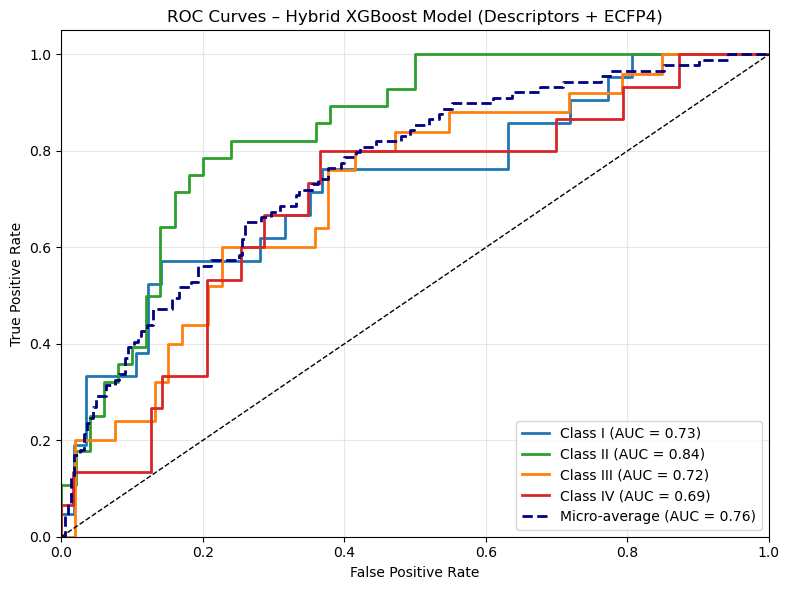

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for each class
y_score = np.array([est.predict_proba(X_test)[:, 1] for est in xgb.estimators_]).T

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8,6))
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
class_labels = ['I', 'II', 'III', 'IV']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='navy', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Hybrid XGBoost Model (Descriptors + ECFP4)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# So far the best accuracy achieved!

Trying CatBoost

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, classification_report

df = processed_df.copy()

df.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in df.select_dtypes(include=[np.number]).columns:
    med = df[col].median(skipna=True)
    df[col].fillna(med, inplace=True)
    df[col] = np.clip(df[col], -1e6, 1e6)

descriptor_cols = [
    'MolWt','HeavyAtomCount','NumRotatableBonds','TPSA','LabuteASA',
    'MolLogP','MolMR','FractionCSP3','NumHDonors','NumHAcceptors',
    'RingCount','QED','BalabanJ','BertzCT','Ipc','FormalCharge',
    'RadicalElectrons','logS'
]
X_desc = df[descriptor_cols].copy()
Y = df[['I','II','III','IV']].astype(int).values

continuous_features = ['MolWt','LabuteASA','MolLogP','MolMR','FractionCSP3','BalabanJ','BertzCT','Ipc','TPSA','logS']
count_features = ['HeavyAtomCount','NumRotatableBonds','NumHAcceptors','NumHDonors','RingCount','FormalCharge','RadicalElectrons']
qed_feature = ['QED']

cont_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler(quantile_range=(25.0, 75.0)))
])
count_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
qed_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

preprocessor = ColumnTransformer([
    ('cont', cont_pipe, continuous_features),
    ('qed',  qed_pipe,  qed_feature),
    ('count',count_pipe, count_features)
], remainder='drop')

X_desc_scaled = preprocessor.fit_transform(X_desc)

def bitstring_to_array(bitstr):
    if isinstance(bitstr, str):
        return np.array([int(c) for c in bitstr], dtype=np.int8)
    else:
        return np.zeros(1024, dtype=np.int8)

ecfp_matrix = np.vstack(df['ECFP4'].apply(bitstring_to_array).values)

X_hybrid = np.hstack([X_desc_scaled, ecfp_matrix])

X_train, X_test, y_train, y_test = train_test_split(
    X_hybrid, Y, test_size=0.2, random_state=42
)

C:\Users\HariK\AppData\Local\Temp\ipykernel_10688\920171885.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(med, inplace=True)
C:\Users\HariK\AppData\Local\Temp\ipykernel_10688\920171885.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [11]:
# 8) CatBoost One-vs-Rest
from catboost import CatBoostClassifier

# CatBoost base configuration; adjust iterations/depth if you have more compute
base_cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    loss_function='Logloss', 
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

clf_cb = OneVsRestClassifier(base_cb, n_jobs=-1)

# 9) Train and evaluate
def evaluate_model(model, X_train, y_train, X_test, y_test, cv_folds=3):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        'subset_acc': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'hamming_loss': hamming_loss(y_test, y_pred),
    }
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_macro', n_jobs=-1)
    metrics['cv_f1_mean'] = float(np.mean(cv_scores))
    metrics['cv_f1_std'] = float(np.std(cv_scores))
    return metrics, y_pred

print("Training CatBoost (Hybrid)...")
cb_metrics, cb_pred = evaluate_model(clf_cb, X_train, y_train, X_test, y_test)
print("CatBoost metrics:", cb_metrics)

print("\nCatBoost Classification Report (Hybrid):")
print(classification_report(y_test, cb_pred, target_names=['I','II','III','IV'], zero_division=0))

Training CatBoost (Hybrid)...
CatBoost metrics: {'subset_acc': 0.3333333333333333, 'f1_macro': 0.37946336429308564, 'hamming_loss': 0.2724358974358974, 'cv_f1_mean': 0.3779338226619025, 'cv_f1_std': 0.013419788109329296}

CatBoost Classification Report (Hybrid):
              precision    recall  f1-score   support

           I       0.46      0.29      0.35        21
          II       0.59      0.61      0.60        28
         III       0.54      0.28      0.37        25
          IV       0.40      0.13      0.20        15

   micro avg       0.53      0.36      0.43        89
   macro avg       0.50      0.33      0.38        89
weighted avg       0.51      0.36      0.41        89
 samples avg       0.39      0.38      0.38        89




Confusion Matrix:
[[13  5  4  0]
 [ 9 17  1  1]
 [10  3  6  0]
 [ 4  4  1  0]]


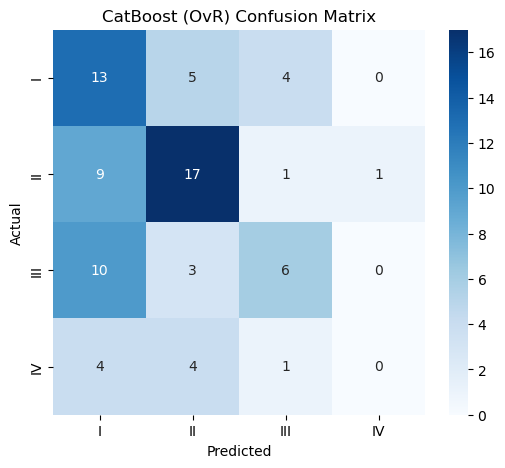

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(cb_pred, axis=1)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(cb_pred, axis=1)

cm = confusion_matrix(y_true_single, y_pred_single)

print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['I','II','III','IV'],
            yticklabels=['I','II','III','IV'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CatBoost (OvR) Confusion Matrix")
plt.show()



In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, hamming_loss, f1_score, classification_report,
    roc_curve, auc, cohen_kappa_score, matthews_corrcoef
)
from catboost import CatBoostClassifier

In [25]:
OUTPUT_DIR = "./artifacts_bcs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
np.random.seed(42)

In [27]:
# 1) Save preprocessor
with open(os.path.join(OUTPUT_DIR, "preprocessor.pkl"), "wb") as f:
    pickle.dump(preprocessor, f)

# 2) Save OVR wrapper via pickle (portable within Python)
with open(os.path.join(OUTPUT_DIR, "catboost_ovr.pkl"), "wb") as f:
    pickle.dump(clf_cb, f)

# 3) Also save each CatBoost binary model (.cbm) per label for portability
if hasattr(clf_cb, "estimators_"):
    for i, est in enumerate(clf_cb.estimators_):
        est.save_model(os.path.join(OUTPUT_DIR, f"catboost_label_{labels[i]}.cbm"))

# 4) Save descriptor names for reproducibility
with open(os.path.join(OUTPUT_DIR, "descriptor_columns.json"), "w") as f:
    import json
    json.dump({
        "descriptor_cols": descriptor_cols,
        "continuous_features": continuous_features,
        "count_features": count_features,
        "qed_feature": qed_feature,
        "labels": labels
    }, f, indent=2)

print(f"\nArtifacts saved to: {os.path.abspath(OUTPUT_DIR)}")


Artifacts saved to: C:\Users\HariK\Documents\Codes\drugbank_all_full_database.xml\extraction\artifacts_bcs


# 


Cohen's Kappa per label:
  I: 0.1852
  II: 0.3643
  III: 0.1910
  IV: 0.1149

Macro Kappa: 0.2138
Micro Kappa: 0.2594

MCC per label:
  I: 0.1939
  II: 0.3644
  III: 0.2089
  IV: 0.1379

Macro MCC: 0.2263
Micro MCC: 0.2681


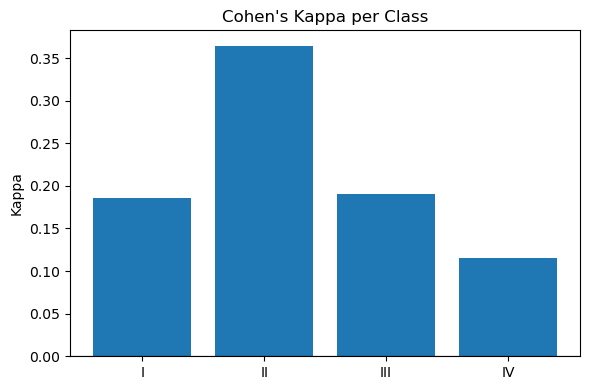

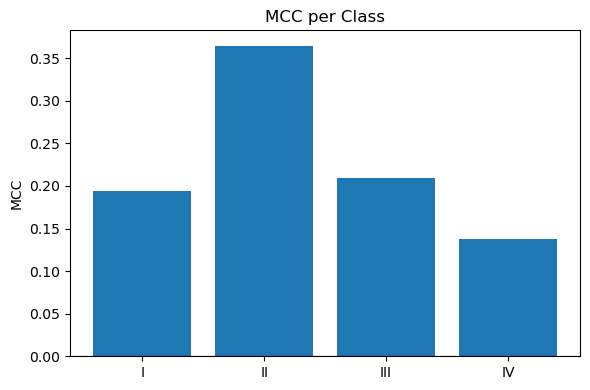


Hybrid CatBoost Metrics Summary
Test subset accuracy: 0.3333
Test F1 macro: 0.3795
Hamming loss: 0.2724
CV F1 macro (mean ± std): 0.3779 ± 0.0134

ROC AUC per class:
  I: 0.7460
  II: 0.8157
  III: 0.6996
  IV: 0.6963
Micro-average AUC: 0.7493

Cohen's Kappa Interpretation:
<0.20: Poor
0.21–0.40: Fair
0.41–0.60: Moderate
0.61–0.80: Good
0.81–1.00: Excellent

MCC Interpretation:
-1: Total disagreement
 0: Random performance
+1: Perfect prediction


In [31]:
# Cohen's Kappa and MCC (Direct Output + Plots) — FIXED
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# Use cb_pred from the first snippet
y_pred = cb_pred  # <-- fix: bring predictions from CatBoost

kappa_per_label = {}
mcc_per_label = {}

# Per-label Kappa and MCC
for i, lab in enumerate(labels):
    kappa_per_label[lab] = cohen_kappa_score(y_test[:, i], y_pred[:, i])
    mcc_per_label[lab]   = matthews_corrcoef(y_test[:, i], y_pred[:, i])

# Macro averages
kappa_macro = float(np.mean(list(kappa_per_label.values())))
mcc_macro   = float(np.mean(list(mcc_per_label.values())))

# Micro averages (flattened)
kappa_micro = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
mcc_micro   = matthews_corrcoef(y_test.ravel(), y_pred.ravel())

# Print results
print("\nCohen's Kappa per label:")
for lab, val in kappa_per_label.items():
    print(f"  {lab}: {val:.4f}")

print(f"\nMacro Kappa: {kappa_macro:.4f}")
print(f"Micro Kappa: {kappa_micro:.4f}")

print("\nMCC per label:")
for lab, val in mcc_per_label.items():
    print(f"  {lab}: {val:.4f}")

print(f"\nMacro MCC: {mcc_macro:.4f}")
print(f"Micro MCC: {mcc_micro:.4f}")

# Display plots directly (no saving)
def show_bar(values_dict, title, ylabel):
    items = list(values_dict.items())
    labs = [k for k, _ in items]
    vals = [v for _, v in items]

    plt.figure(figsize=(6,4))
    plt.bar(labs, vals)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot Kappa and MCC
show_bar(kappa_per_label, "Cohen's Kappa per Class", "Kappa")
show_bar(mcc_per_label,   "MCC per Class",           "MCC")

# Print full metrics summary (pull values from cb_metrics and roc_auc computed in the first snippet)
print("\n============================")
print("Hybrid CatBoost Metrics Summary")
print("============================")
print(f"Test subset accuracy: {cb_metrics['subset_acc']:.4f}")
print(f"Test F1 macro: {cb_metrics['f1_macro']:.4f}")
print(f"Hamming loss: {cb_metrics['hamming_loss']:.4f}")
print(f"CV F1 macro (mean ± std): {cb_metrics['cv_f1_mean']:.4f} ± {cb_metrics['cv_f1_std']:.4f}")

print("\nROC AUC per class:")
for lab in labels:
    print(f"  {lab}: {roc_auc[labels.index(lab)]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")

print("\nCohen's Kappa Interpretation:")
print("<0.20: Poor")
print("0.21–0.40: Fair")
print("0.41–0.60: Moderate")
print("0.61–0.80: Good")
print("0.81–1.00: Excellent")

print("\nMCC Interpretation:")
print("-1: Total disagreement")
print(" 0: Random performance")
print("+1: Perfect prediction")


In [ ]:
"""
# Example inference usage:

import pickle, json
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

# Load artifacts
with open('./artifacts_bcs/preprocessor.pkl','rb') as f:
    preprocessor = pickle.load(f)
with open('./artifacts_bcs/catboost_ovr.pkl','rb') as f:
    clf_cb = pickle.load(f)

# new_df must contain the same descriptor columns + an 'ECFP4' bitstring column
new_df = pd.DataFrame([...])  # fill with your rows
X_desc_new = new_df[descriptor_cols].copy()
X_desc_new_scaled = preprocessor.transform(X_desc_new)

def bitstring_to_array(bitstr):
    return np.array([int(c) for c in bitstr], dtype=np.int8)

ecfp_new = np.vstack(new_df['ECFP4'].apply(bitstring_to_array).values)
X_new = np.hstack([X_desc_new_scaled, ecfp_new])

# Predict multilabel outputs
y_new = clf_cb.predict(X_new)            # shape (n_samples, 4)
y_proba = np.column_stack([est.predict_proba(X_new)[:,1] for est in clf_cb.estimators_])

print(y_new)
print(y_proba)
"""

In [26]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, QED, GraphDescriptors
import numpy as np
import pandas as pd
from catboost import Pool

descriptor_feature_names = list(continuous_features) + list(qed_feature) + list(count_features)
ecfp_feature_names = [f"ECFP4_{i}" for i in range(1024)]
feature_names = descriptor_feature_names + ecfp_feature_names

# Check alignment
n_desc = len(descriptor_feature_names)
n_ecfp = len(ecfp_feature_names)

# 2) Human-friendly short descriptions for key descriptors
descriptor_gloss = {
    "MolWt": "Molecular weight (size/mass of the molecule)",
    "LabuteASA": "Approximate solvent-accessible surface area",
    "MolLogP": "Lipophilicity (octanol/water partition, logP)",
    "MolMR": "Molar refractivity (volume/polarizability proxy)",
    "FractionCSP3": "Fraction of sp3 carbons (3D saturation)",
    "BalabanJ": "Balaban J topological index (shape/branching)",
    "BertzCT": "Bertz complexity index (molecular complexity)",
    "Ipc": "Information content index (branching/complexity)",
    "TPSA": "Topological polar surface area (polarity/H-bonding)",
    "logS": "Predicted aqueous solubility (logS)",
    "HeavyAtomCount": "Count of heavy atoms (non-H)",
    "NumRotatableBonds": "Flexibility (rotatable bonds)",
    "NumHAcceptors": "Hydrogen bond acceptors",
    "NumHDonors": "Hydrogen bond donors",
    "RingCount": "Number of rings",
    "FormalCharge": "Net formal charge",
    "RadicalElectrons": "Unpaired electrons (radical character)",
    "QED": "Drug-likeness (QED score)"
}

# 3) Dataset medians so we can say "higher/lower than typical"
DESC_MEDIANS = df[descriptor_cols].median()

# # 4) Helpers to compute descriptors and ECFP4 from SMILES
def smiles_to_ecfp4_array(smiles: str, n_bits: int = 1024) -> np.ndarray:
    if not isinstance(smiles, str) or len(smiles.strip()) == 0:
        raise ValueError("SMILES is empty.")
    mol = Chem.MolFromSmiles(smiles.strip())
    if mol is None:
        raise ValueError("Invalid SMILES.")
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return np.array(fp, dtype=np.int8)  # 0/1 vector

def smiles_to_descriptors(smiles: str) -> pd.Series:
    mol = Chem.MolFromSmiles(smiles.strip())
    if mol is None:
        raise ValueError("Invalid SMILES for descriptor calculation.")
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
        'NumRotatableBonds': rdMolDescriptors.CalcNumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol),
        'LabuteASA': rdMolDescriptors.CalcLabuteASA(mol),
        'MolLogP': rdMolDescriptors.CalcCrippenDescriptors(mol)[0],
        'MolMR': rdMolDescriptors.CalcCrippenDescriptors(mol)[1],
        'FractionCSP3': rdMolDescriptors.CalcFractionCSP3(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'RingCount': Descriptors.RingCount(mol),
        'QED': QED.qed(mol),
        'BalabanJ': GraphDescriptors.BalabanJ(mol),
        'BertzCT': GraphDescriptors.BertzCT(mol),
        'Ipc': GraphDescriptors.Ipc(mol),
        'FormalCharge': Chem.GetFormalCharge(mol),
        'RadicalElectrons': Descriptors.NumRadicalElectrons(mol),
        # You trained with a predicted logS column. If you want runtime logS from your regressor,
        # call it here. Otherwise omit or set to a proxy. For now, set to NaN so preprocessor imputes.
        'logS': np.nan
    })[descriptor_cols]  # enforce training order

# 5) Core explainer: returns a dict and prints a readable summary
def explain_drug_from_smiles(
    smiles: str,
    class_choice: str = "auto",
    top_k_desc: int = 6,
    threshold: float = 0.5
):
    # Compute inputs
    desc_series = smiles_to_descriptors(smiles)
    ecfp = smiles_to_ecfp4_array(smiles, n_bits=1024)

    # Basic cleaning like training
    desc_df = pd.DataFrame([desc_series])
    for col in desc_df.columns:
        val = desc_df.at[0, col]
        if pd.isna(val) or np.isinf(val):
            # median imputation fallback
            med = DESC_MEDIANS.get(col, np.nan)
            desc_df.at[0, col] = med if pd.notna(med) else 0.0
        desc_df.at[0, col] = float(np.clip(desc_df.at[0, col], -1e6, 1e6))

    # Transform descriptors, then build hybrid row
    X_desc_scaled = preprocessor.transform(desc_df)  # shape (1, n_desc_after_pipeline) -> same order as training
    # The pipeline output order must match descriptor_feature_names. We constructed descriptor_feature_names
    # as [continuous_features + qed_feature + count_features], which is the same order used in preprocessor.
    assert X_desc_scaled.shape[1] == n_desc, "Descriptor count mismatch with training feature order."

    X_hybrid_row = np.hstack([X_desc_scaled, ecfp.reshape(1, -1)])  # shape (1, n_desc + 1024)
    if X_hybrid_row.shape[1] != (n_desc + n_ecfp):
        raise RuntimeError("Hybrid feature width mismatch.")

    # Predict probabilities for each class
    probs = np.array([est.predict_proba(X_hybrid_row)[0, 1] for est in clf_cb.estimators_])
    preds = (probs >= threshold).astype(int)

    # Choose class to explain
    if class_choice == "auto":
        cls_id = int(np.argmax(probs))
    else:
        cls_id = labels.index(class_choice)

    target_label = labels[cls_id]
    target_proba = float(probs[cls_id])
    target_pred = int(preds[cls_id])

    # SHAP contributions for this sample and target class
    est = clf_cb.estimators_[cls_id]
    shap_vals = est.get_feature_importance(Pool(X_hybrid_row, label=None), type='ShapValues')  # (1, n_features+1)
    contrib = shap_vals[0, :-1]
    bias = shap_vals[0, -1]

    # Split into descriptor vs ECFP
    desc_contrib = contrib[:n_desc]
    ecfp_contrib = contrib[n_desc:]
    desc_abs = float(np.sum(np.abs(desc_contrib)))
    ecfp_abs = float(np.sum(np.abs(ecfp_contrib)))
    total_abs = desc_abs + ecfp_abs + 1e-12
    desc_share = desc_abs / total_abs
    ecfp_share = ecfp_abs / total_abs

    # Top-k descriptor contributors
    order = np.argsort(np.abs(desc_contrib))[::-1][:top_k_desc]
    top_desc = []
    for j in order:
        name = descriptor_feature_names[j]
        raw_val = float(desc_df.iloc[0][name])
        med = float(DESC_MEDIANS.get(name, np.nan))
        direction = "higher than" if raw_val > med else ("lower than" if raw_val < med else "around")
        gloss = descriptor_gloss.get(name, "Descriptor")
        top_desc.append({
            "name": name,
            "meaning": gloss,
            "value": raw_val,
            "median": med,
            "vs_median": direction,
            "contribution": float(desc_contrib[j]),
            "effect": "toward" if desc_contrib[j] >= 0 else "against"
        })

    # Compose human text
    print("====================================")
    print("Drug explanation from SMILES")
    print("------------------------------------")
    print(f"SMILES: {smiles}")
    print("Predicted probabilities per class:")
    for i, lab in enumerate(labels):
        print(f"  {lab}: {probs[i]:.3f}")
    print(f"Explained class: {target_label}")
    print(f"Predicted label (>= {threshold}): {target_pred}, probability: {target_proba:.3f}")
    print("------------------------------------")
    print("Overall influence split:")
    print(f"  Descriptors: {desc_share*100:.1f}%")
    print(f"  ECFP4 structural bits: {ecfp_share*100:.1f}%")
    print("------------------------------------")
    print("Top descriptor drivers for this decision:")
    for d in top_desc:
        print(f"- {d['name']} ({d['meaning']}): value {d['value']:.3g}, "
              f"{d['vs_median']} dataset median ({d['median']:.3g}); "
              f"contribution {d['contribution']:+.4f} -> {d['effect']} this class.")
    print("------------------------------------")
    if ecfp_share >= 0.5:
        print("Interpretation of structure: The decision is predominantly driven by structural fragments captured by ECFP4.")
    else:
        print("Interpretation of structure: Scalar descriptors contributed more than structural fragments for this decision.")
    class_summary = {
        "I":  "Typically aligned with higher solubility and permeability signatures.",
        "II": "Often driven by higher lipophilicity and lower solubility patterns.",
        "III":"Often driven by higher polarity (TPSA/HBA/HBD) and lower permeability signatures.",
        "IV": "Ambiguous region where both solubility and permeability tend to be limiting."
    }
    print("Class-level context:")
    print(f"  {class_summary.get(target_label, '')}")
    print("====================================")

    # Return machine-friendly payload for UI
    return {
        "smiles": smiles,
        "probabilities": {labels[i]: float(probs[i]) for i in range(len(labels))},
        "threshold": float(threshold),
        "explained_class": target_label,
        "predicted_flag": int(target_pred),
        "predicted_prob": float(target_proba),
        "descriptor_share": float(desc_share),
        "ecfp_share": float(ecfp_share),
        "top_descriptors": top_desc,
        "bias_term": float(bias)
    }

# --------------------------
# Example usage:
# result = explain_drug_from_smiles("CCOc1ccc2nc(S(N)(=O)=O)sc2c1")
# result = explain_drug_from_smiles("SMILES_HERE", class_choice="II", top_k_desc=8)


In [28]:
result = explain_drug_from_smiles("CCOc1ccc2nc(S(N)(=O)=O)sc2c1")


Drug explanation from SMILES
------------------------------------
SMILES: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
Predicted probabilities per class:
  I: 0.069
  II: 0.850
  III: 0.022
  IV: 0.109
Explained class: II
Predicted label (>= 0.5): 1, probability: 0.850
------------------------------------
Overall influence split:
  Descriptors: 45.3%
  ECFP4 structural bits: 54.7%
------------------------------------
Top descriptor drivers for this decision:
- MolLogP (Lipophilicity (octanol/water partition, logP)): value 1.34, lower than dataset median (2.63); contribution -0.8478 -> against this class.
- logS (Predicted aqueous solubility (logS)): value -2.69, around dataset median (-2.69); contribution +0.8384 -> toward this class.
- QED (Drug-likeness (QED score)): value 0.9, higher than dataset median (0.569); contribution +0.5769 -> toward this class.
- FractionCSP3 (Fraction of sp3 carbons (3D saturation)): value 0.222, lower than dataset median (0.368); contribution +0.3270 -> toward this clas

[12:26:07] DEPRECATION WARNING: please use MorganGenerator
